# Multi-class Classification

We will use PySpark to predict student dropout and academic success

In [1]:
# Set the `JAVA_HOME` environment variable to point to the OpenJDK installation directory
# This is necessary for Spark to interact with the Java runtime on macOS with Apple Silicon
# Replace '/opt/homebrew/opt/openjdk' with your actual installation path if different
import os
os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

# Create a SparkSession named 'SparkBasics'
# This is the entry point for working with Spark SQL
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkBasics').getOrCreate()

# Fetch public dataset
from ucimlrepo import fetch_ucirepo 


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/10 22:42:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 49808)
Traceback (most recent call last):
  File "/Users/mridul/deeplearning/Pyspark/venv/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/mridul/deeplearning/Pyspark/venv/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/Users/mridul/deeplearning/Pyspark/venv/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/mridul/deeplearning/Pyspark/venv/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/Users/mridul/deeplearning/Pyspark/venv/lib/python3.11/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Users/mridul/deeplearning/Pyspark/venv/lib/python3.11/site-packages/pyspark/a

In [2]:
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 

# Combine X (features) and y (targets) into a single DataFrame
df_pandas = pd.concat([X, y], axis=1)
df_pandas.head()
  
# metadata 
#print(predict_students_dropout_and_academic_success.metadata) 
  
# variable information 
#print(predict_students_dropout_and_academic_success.variables) 


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [3]:
# Convert the pandas DataFrame to a Spark DataFrame
df_spark = spark.createDataFrame(df_pandas)
df_spark.show()

24/06/10 22:42:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+----------------+-----------------+------+--------------------------+----------------------+------------------------------+-----------+----------------------+----------------------+-------------------+-------------------+---------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------+--------------+-----+--------+
|Marital Status|Application mode|Application order|Course|Daytime/evening attendance|Previous qualification|Previous qu

In [4]:
# Create a StringIndexer for the target column 'Target'
indexer = StringIndexer(inputCol="Target", outputCol="Target_indexed")

# Create a Pipeline object
pipeline = Pipeline(stages=[indexer])

# Fit the pipeline to the data (learn the mapping)
pipeline_model = pipeline.fit(df_spark)

# Transform the DataFrame using the fitted pipeline
df_spark = pipeline_model.transform(df_spark)

# Display the transformed DataFrame
df_spark.show()

+--------------+----------------+-----------------+------+--------------------------+----------------------+------------------------------+-----------+----------------------+----------------------+-------------------+-------------------+---------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------+--------------+-----+--------+--------------+
|Marital Status|Application mode|Application order|Course|Daytime/evening attendance|Previous qualificat

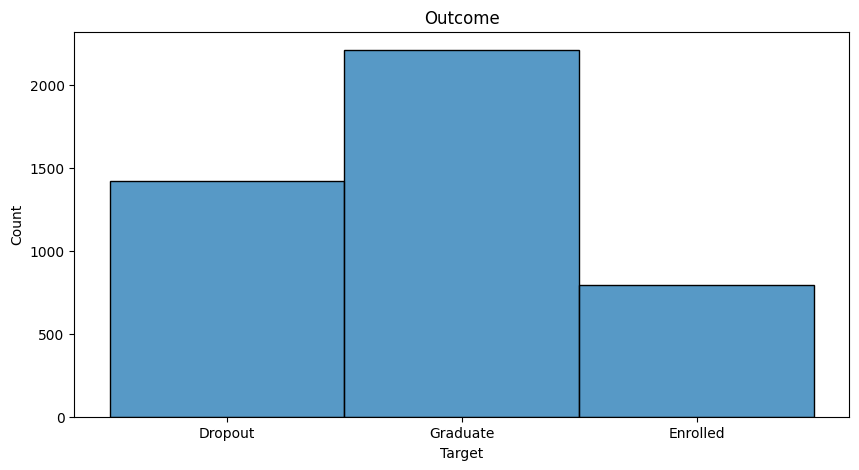

In [5]:
plt.figure(figsize=(10,5))
plt.title('Outcome')
sns.histplot(df_pandas['Target']);

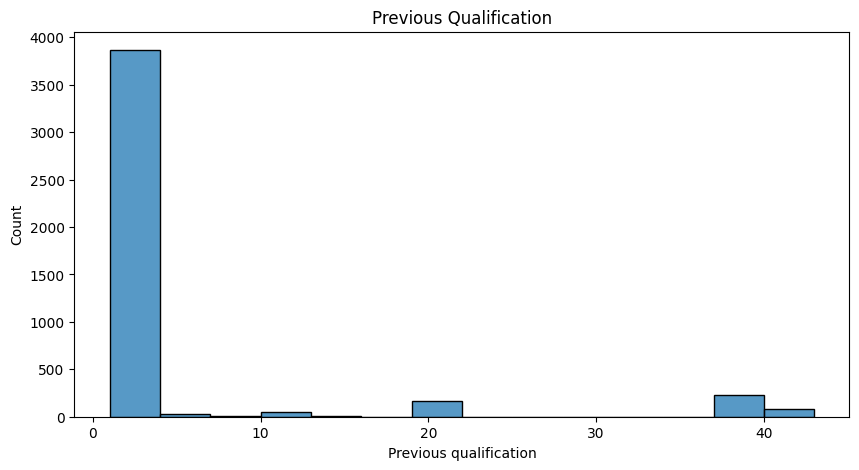

In [6]:
plt.figure(figsize=(10,5))
plt.title('Previous Qualification')
sns.histplot(df_pandas['Previous qualification']);

## Data Preprocessing

In [7]:
# Check for null values
from pyspark.sql.functions import isnan, when, count, col

df_spark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_spark.columns]).show()


+--------------+----------------+-----------------+------+--------------------------+----------------------+------------------------------+-----------+----------------------+----------------------+-------------------+-------------------+---------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------+--------------+---+------+--------------+
|Marital Status|Application mode|Application order|Course|Daytime/evening attendance|Previous qualification|

In [8]:

df_spark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_spark.columns]).show()

+--------------+----------------+-----------------+------+--------------------------+----------------------+------------------------------+-----------+----------------------+----------------------+-------------------+-------------------+---------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------+--------------+---+------+--------------+
|Marital Status|Application mode|Application order|Course|Daytime/evening attendance|Previous qualification|

In [9]:
# Checking the average age by Initials
df_spark.groupby('Course').count().collect()


[Row(Course=9070, count=226),
 Row(Course=9130, count=141),
 Row(Course=9119, count=170),
 Row(Course=33, count=12),
 Row(Course=9670, count=268),
 Row(Course=9773, count=331),
 Row(Course=171, count=215),
 Row(Course=9991, count=268),
 Row(Course=9556, count=86),
 Row(Course=9500, count=766),
 Row(Course=9003, count=210),
 Row(Course=9085, count=337),
 Row(Course=9853, count=192),
 Row(Course=9147, count=380),
 Row(Course=8014, count=215),
 Row(Course=9254, count=252),
 Row(Course=9238, count=355)]

In [10]:
# Before modelling in pyspark, we convert the features into vector
features = VectorAssembler(inputCols = df_spark.columns[:-2], outputCol="features")
feature_vector = features.transform(df_spark)
feature_vector.limit(5).toPandas()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Target_indexed,features
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1.0,"(1.0, 17.0, 5.0, 171.0, 1.0, 1.0, 122.0, 1.0, ..."
1,1,15,1,9254,1,1,160.0,1,1,3,...,6,6,13.666667,0,13.9,-0.3,0.79,Graduate,0.0,"[1.0, 15.0, 1.0, 9254.0, 1.0, 1.0, 160.0, 1.0,..."
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1.0,"(1.0, 1.0, 5.0, 9070.0, 1.0, 1.0, 122.0, 1.0, ..."
3,1,17,2,9773,1,1,122.0,1,38,37,...,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate,0.0,"[1.0, 17.0, 2.0, 9773.0, 1.0, 1.0, 122.0, 1.0,..."
4,2,39,1,8014,0,1,100.0,1,37,38,...,6,6,13.000000,0,13.9,-0.3,0.79,Graduate,0.0,"[2.0, 39.0, 1.0, 8014.0, 0.0, 1.0, 100.0, 1.0,..."


## Create train and test set

In [11]:
# Select features column for features training and 'Target' as label to predict
df_model = feature_vector.select(['features','Target_indexed'])

# Split the dataset to train_df and test_df
df_train, df_test = df_model.randomSplit([0.80,0.20])

## Logistic Regression

In [12]:
# LOAD PYSPARK LIBRARIES
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# DEFINE ALGORITHM 
lr = LogisticRegression(labelCol="Target_indexed")

# DEFINE GRID PARAMETERS
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

# DEFINE CROSS VALIDATION WITH PARAMETERS
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Target_indexed')
                           ,trainRatio=0.8)
model = tvs.fit(df_train)
model_predictions= model.transform(df_test)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Target_indexed',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Target_indexed',metricName='weightedPrecision').evaluate(model_predictions))

24/06/10 22:42:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/10 22:42:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/06/10 22:42:40 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Accuracy:  0.7488532110091743
Precision:  0.7211924146639515


## Random Forest

In [13]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
rf = RandomForestClassifier(labelCol='Target_indexed')
paramGrid = ParamGridBuilder()\
                                .addGrid(rf.maxDepth, [5, 10, 20]) \
                                .addGrid(rf.maxBins, [20, 32, 50]) \
                                .addGrid(rf.numTrees, [20, 40, 60 ]) \
                                .addGrid(rf.impurity, ["gini", "entropy"]) \
                                .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
                                .build()


tvs = TrainValidationSplit( estimator=rf
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Target_indexed')
                           ,trainRatio=0.8)
model = tvs.fit(df_train)
model_predictions= model.transform(df_test)


print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Target_indexed',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Target_indexed',metricName='weightedPrecision').evaluate(model_predictions))

24/06/10 22:43:13 WARN DAGScheduler: Broadcasting large task binary with size 1196.9 KiB
24/06/10 22:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1015.2 KiB
24/06/10 22:43:15 WARN DAGScheduler: Broadcasting large task binary with size 1205.3 KiB
24/06/10 22:43:16 WARN DAGScheduler: Broadcasting large task binary with size 1031.8 KiB
24/06/10 22:43:17 WARN DAGScheduler: Broadcasting large task binary with size 1145.6 KiB
24/06/10 22:43:17 WARN DAGScheduler: Broadcasting large task binary with size 1628.3 KiB
24/06/10 22:43:17 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/10 22:43:18 WARN DAGScheduler: Broadcasting large task binary with size 1646.0 KiB
24/06/10 22:43:18 WARN DAGScheduler: Broadcasting large task binary with size 1102.5 KiB
24/06/10 22:43:18 WARN DAGScheduler: Broadcasting large task binary with size 1486.6 KiB
24/06/10 22:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1898.8 KiB
24/06/10 22:43:19 WARN D

Accuracy:  0.7511467889908257


24/06/10 22:46:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


Precision:  0.729769601545398


24/06/11 00:36:01 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1900740 ms exceeds timeout 120000 ms
24/06/11 00:36:01 WARN SparkContext: Killing executors is not supported by current scheduler.
24/06/11 00:36:02 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$